In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import moscot
from anndata import AnnData
import numpy as np
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver
from moscot.solvers._tagged_arry import TaggedArray, Tag
import matplotlib.pyplot as plt
import jax.numpy as jnp
from typing import *
import pandas as pd
import networkx as nx
import jax.numpy as jnp
from moscot.problems.time._lineage import TemporalProblem
import os
import wot
from functools import partial

In [3]:
import scanpy as sc
import matplotlib as mpl

In [4]:
import ott
import ot
from tqdm import tqdm

In [5]:
data_path = "/home/icb/dominik.klein/data/wot"


VAR_GENE_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
SERUM_CELL_IDS_PATH = os.path.join(data_path, 'serum_cell_ids.txt')
CELL_GROWTH_PATH = os.path.join(data_path, 'growth_gs_init.txt')
FULL_DS_PATH = os.path.join(data_path, 'ExprMatrix.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
VAR_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
TMAP_PATH = os.path.join(data_path, 'serum')
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
COORDS_PATH = os.path.join(data_path, 'fle_coords.txt')

In [ ]:
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

In [ ]:
sc.tl.pca(adata)

In [ ]:
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
cell_to_type = {v[i]: k for k, v in cell_sets.items() for i in range(len(v))}
df_cell_type = pd.DataFrame(cell_to_type.items(), columns=["0", "cell_type"]).set_index("0")
adata.obs = pd.merge(adata.obs, df_cell_type, how="left", left_index=True, right_index=True)

In [ ]:
days = list(adata.obs.day.unique())
days.pop(-1) # remove nan

## Run WOT

In [ ]:
#ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

In [ ]:
#tmap_annotated = ot_model.compute_transport_map(11,11.5)

## Run Moscot

In [ ]:
tp = TemporalProblem(adata, solver=SinkhornSolver(jit=False, rank=500))

In [ ]:
adata.obs.day = adata.obs.day.astype('category')

In [ ]:
tp.prepare("day", x={"attr": "obsm", "key": "X_pca"}, y={"attr": "obsm", "key": "X_pca"}, a_marg={"attr": "obs", "key":"cell_growth_rate"})

In [ ]:
lambda_1 = 1.0
eps = 5.0
tp.solve(eps=eps, tau_a=lambda_1/(lambda_1+eps), tau_b=1)

## Pull back mass

In [16]:
adata[adata.obs.day==18.0].obs.cell_type.value_counts(dropna=False)

Stromal        1239
Neural          819
NaN             534
Epithelial      503
IPS             412
Trophoblast     292
Name: cell_type, dtype: int64

In [17]:
adata[adata.obs.day==18.0]

View of AnnData object with n_obs × n_vars = 3799 × 1479
    obs: 'day', 'cell_growth_rate', 'cell_type'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [18]:
#for i in range(38):
#    print(adata.uns[f"cost_matrix_{i}"].shape)

In [26]:
result = tp.pull_back_composed(start=0, end=18, key_groups="cell_type", groups=["IPS"], return_all=True)

(17.5, 18.0)
data.shape (3799, 1)
x.shape before apply (3799, 1)
res.shape after apply (4068,)
(17.0, 17.5)
data.shape (4068, 1)
x.shape before apply (4068, 1)
res.shape after apply (3678,)
(16.5, 17.0)
data.shape (3678, 1)
x.shape before apply (3678, 1)
res.shape after apply (4645,)
(16.0, 16.5)
data.shape (4645, 1)
x.shape before apply (4645, 1)
res.shape after apply (3422,)
(15.5, 16.0)
data.shape (3422, 1)
x.shape before apply (3422, 1)
res.shape after apply (4851,)
(15.0, 15.5)
data.shape (4851, 1)
x.shape before apply (4851, 1)
res.shape after apply (3717,)
(14.5, 15.0)
data.shape (3717, 1)
x.shape before apply (3717, 1)
res.shape after apply (2723,)
(14.0, 14.5)
data.shape (2723, 1)
x.shape before apply (2723, 1)
res.shape after apply (3758,)
(13.5, 14.0)
data.shape (3758, 1)
x.shape before apply (3758, 1)
res.shape after apply (2034,)
(13.0, 13.5)
data.shape (2034, 1)
x.shape before apply (2034, 1)
res.shape after apply (2145,)
(12.5, 13.0)
data.shape (2145, 1)
x.shape before a

In [57]:
result[3].shape

(4645,)

In [80]:
jnp.dot(tmp.q, jnp.dot(tmp.r.T, a) / tmp.g)
#jnp.dot(tmp.r, jnp.dot(tmp.q.T, a) / tmp.g)

DeviceArray([0.00017113, 0.00043556, 0.00024156, ..., 0.00017113,
             0.00016322, 0.00024156], dtype=float32)

In [45]:
a = np.ones(3799)
a_2 = np.ones(3800)

In [52]:
tmp = tp._problems[(17.5,18.0)].pull(a)

data.shape (3799, 1)
now in _output: (3799, 1)
axis is  1


In [56]:
tmp

LRSinkhornOutput(q=DeviceArray([[0.00017113, 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.00017113, 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ]], dtype=float32), r=DeviceArray([[0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.00020834, 0.        ],
             [0.00037809, 0.        , 0.        , ..., 0.        ,
              0.        , 0. 

In [65]:
tmp.g

DeviceArray([0.23514304, 0.05604745, 0.0254516 , 0.04486169, 0.33241096,
             0.14383969, 0.03884709, 0.01502364, 0.04937958, 0.01126312],            dtype=float32)

In [44]:
tp.solution[(17.5,18.0)].pull(a_2)

NameError: name 'a_2' is not defined

In [29]:
np.quantile(result[0], 0.9)

0.0024271844660194173

In [26]:
#result[0].max() > 1e-3

In [27]:
#r_scaled = []
#for r in result:
#    r_min = r.min()
#    r_max = r.max()
#    r_scaled.append((r - r_min)/(r_max - r_min))

In [28]:
#result = r_scaled

## Compare

In [27]:
COORD_DF = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)

In [28]:
nbins = 500
xrange = COORD_DF['x'].min(), COORD_DF['x'].max()
yrange = COORD_DF['y'].min(), COORD_DF['y'].max()
COORD_DF['x'] = np.floor(
    np.interp(COORD_DF['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
COORD_DF['y'] = np.floor(
    np.interp(COORD_DF['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)

In [29]:
bdata = adata.copy()
bdata.obs = bdata.obs.join(COORD_DF)

In [61]:
print(result[i].shape)

(4068,)


In [30]:
percentile_thresholds = [90, 80]
alpha_bins = np.flip(np.linspace(0,1,len(percentile_thresholds)+1))

def bin_alpha(x, thresholds, alpha_bins):
    for i in range(len(thresholds)):
        if x >= thresholds[i]:
            return alpha_bins[-(i+1)]
    
days_reverse = days[::-1]
bdata.obs["alpha_bin"] = np.nan
for i in tqdm(range(len(result))):
    bdata_filtered = bdata[bdata.obs.day==days_reverse[i]]
    assert len(bdata_filtered) == len(result[i]), print(len(bdata_filtered), len(result[i]))
    thresholds = np.percentile(result[i], percentile_thresholds)+1e-8
    #print(len(alpha_bins[np.digitize(result[i], thresholds)]))
    #print(bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"].shape)
    #print(len(bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"]), len(alpha_bins[np.digitize(result[i], thresholds)]))
    print(alpha_bins[np.digitize(result[i], thresholds)].shape)
    bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"] = alpha_bins[np.digitize(result[i], thresholds)]
    
    #bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"] = list(map(partial(bin_alpha, thresholds=thresholds, alpha_bins=alpha_bins), result[i]))

100%|██████████| 39/39 [00:00<00:00, 240.69it/s]

(3799, 1)
(4068,)
(3678,)
(4645,)
(3422,)
(4851,)
(3717,)
(2723,)
(3758,)
(2034,)
(2145,)
(2253,)
(2429,)
(2164,)
(2238,)
(1941,)
(2051,)
(2266,)
(2982,)
(3088,)
(3573,)
(3829,)
(3815,)
(5061,)
(6507,)
(3111,)
(8422,)
(6550,)
(7227,)
(7127,)
(8962,)
(7355,)
(6777,)
(6734,)
(6981,)
(1956,)
(3648,)
(3449,)
(4556,)


In [31]:
bdata.obs.alpha_bin.value_counts()

0.0    153935
0.5      6056
1.0      5901
Name: alpha_bin, dtype: int64

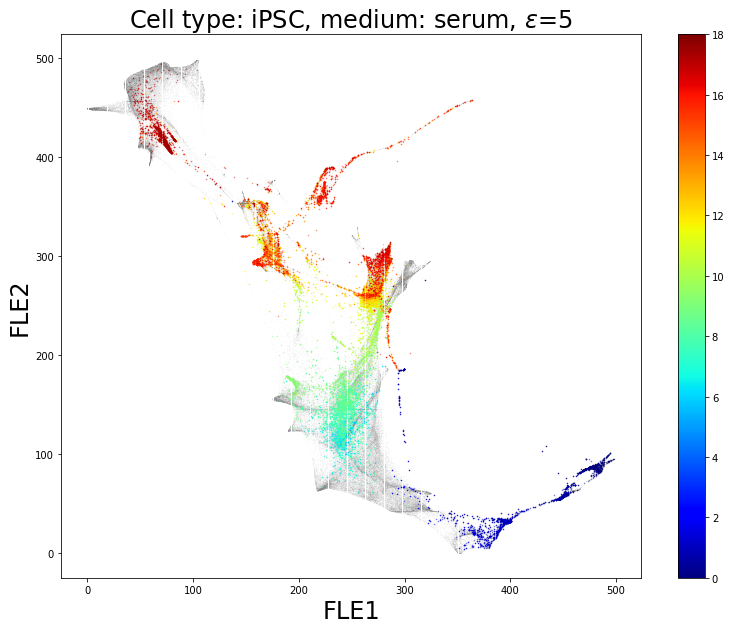

In [32]:
cm = plt.get_cmap('jet')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(result))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(13, 10))
plt.title(f'Cell type: iPSC, medium: serum, $\epsilon$={5}', fontsize=24)
plt.plot(COORD_DF['x'], COORD_DF['y'], marker='.', color='grey', ls='',
         markersize=0.3, alpha=0.07)
for i in range(len(result)):
    colorVal = scalarMap.to_rgba(i)
    for b in alpha_bins:
        colorVal = np.array(colorVal)
        colorVal[3] = b
        plt.plot(bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "x"],
                 bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "y"],
               marker='.', color=colorVal, ls='', markersize=1)
plt.xlabel('FLE1', fontsize=24)
plt.ylabel('FLE2', fontsize=24)
ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cm,
                       norm=mpl.colors.Normalize(vmin=0, vmax=18))
plt.show()

# Test low rank Sinkhorn

In [23]:
import ott
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

def create_points(rng, n, m, d):
  rngs = jax.random.split(rng, 4)
  x = jax.random.normal(rngs[0], (n,d)) + 1
  y = jax.random.uniform(rngs[1], (m,d))
  a = jax.random.uniform(rngs[2], (n,))
  b = jax.random.uniform(rngs[3], (m,))
  a = a / jnp.sum(a)
  b = b / jnp.sum(b)
  return x, y, a, b


In [24]:
rng = jax.random.PRNGKey(0)
n, m, d = 19, 35, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

geom = ott.geometry.pointcloud.PointCloud(x, y, epsilon=0.1)
ot_prob = ott.core.problems.LinearProblem(geom, a, b)


In [25]:
rng = jax.random.PRNGKey(0)
n, m, d = 19, 35, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

geom = ott.geometry.pointcloud.PointCloud(x, y, epsilon=0.1)
ot_prob = ott.core.problems.LinearProblem(geom, a, b)


In [27]:
solver = ott.core.sinkhorn_lr.LRSinkhorn(rank=int(min(n,m)/2))
ot_lr = solver(ot_prob)

In [31]:
np.ones(19)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [32]:
ot_lr.apply(np.ones(19))

DeviceArray([0.05388878, 0.01349156, 0.04265046, 0.00745171, 0.0300949 ,
             0.04246419, 0.01185917, 0.01130359, 0.04318917, 0.03027359,
             0.05184619, 0.00401225, 0.01881211, 0.03039191, 0.0193588 ,
             0.00472911, 0.04933582, 0.04831525, 0.00409654, 0.0267557 ,
             0.04355843, 0.04236978, 0.06161218, 0.02236322, 0.00265439,
             0.01530669, 0.06197171, 0.0248453 , 0.0289845 , 0.01524431,
             0.05585859, 0.01096907, 0.03034744, 0.00312966, 0.03646384],            dtype=float32)

In [41]:
ot_lr

LRSinkhornOutput(q=DeviceArray([[1.92878614e-15, 5.29677546e-09, 3.34489943e-42,
              7.24470317e-22, 1.32264515e-28, 1.33895226e-26,
              1.16816444e-30, 2.20183530e-04, 4.27237712e-02],
             [1.67828335e-10, 2.28699934e-10, 3.26976804e-15,
              3.10280448e-05, 1.73442424e-13, 1.46286195e-21,
              1.45213344e-05, 1.86706446e-02, 3.97161057e-05],
             [1.28070009e-03, 3.55844008e-04, 1.73618980e-02,
              5.54300882e-02, 2.33031716e-03, 3.05950003e-08,
              4.28185194e-06, 5.41592317e-06, 6.48741832e-07],
             [9.12866405e-09, 4.39004211e-09, 2.03596340e-09,
              1.93606445e-03, 4.72107686e-10, 2.55186072e-19,
              5.88389896e-02, 8.82213702e-04, 3.39954531e-05],
             [1.32592453e-08, 3.12148600e-08, 3.56679155e-17,
              2.39403533e-07, 2.55338624e-14, 1.11031394e-19,
              2.10489937e-09, 4.15226705e-02, 3.24651995e-03],
             [5.37938718e-07, 3.47561890e-09, 